In [12]:
import os
path= 'C:\\Users\\MSI\\Desktop\\P2M\\Securing-Medical-Data-Transfer-Using-Deep-Steganography-and-Cryptography-MLflow-DVC'
os.chdir(path)

In [13]:
%pwd

'C:\\Users\\MSI\\Desktop\\P2M\\Securing-Medical-Data-Transfer-Using-Deep-Steganography-and-Cryptography-MLflow-DVC'

In [14]:
#os.chdir("../")

In [15]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class SplitConfig:
    root_dir: Path
    trained_model_path: Path
    hiding_model_path: Path
    reveal_model_path: Path

In [16]:
from cnnClassifier.constants import *
from cnnClassifier.utils.common import read_yaml, create_directories
import numpy as np
import tensorflow as tf

In [17]:
class ConfigurationManager:
    def __init__(
            self,
            config_filepath= CONFIG_FILE_PATH,
            params_filepath = PARAMS_FILE_PATH
    ):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])
    def get_split_config(self) -> SplitConfig:
        model_split = self.config.model_split
        create_directories([
            Path(model_split.root_dir)
        ])

        split_config = SplitConfig(
            root_dir=Path(model_split.root_dir),
            trained_model_path=Path(model_split.trained_model_path),
            hiding_model_path = Path(model_split.hiding_model_path),
            reveal_model_path = Path(model_split.reveal_model_path)
        )

        return split_config

In [18]:
import sys
from keras.models import Model
from keras.layers import Dense, Input, concatenate, Conv2D
from keras.models import load_model
from keras.utils import plot_model

In [19]:
from src.cnnClassifier.utils.common import custom_loss_1,custom_loss_2

In [20]:
class SplitModel:
    def __init__(self, config: SplitConfig):
        self.config = config
    def get_base_model(self):
        self.model = tf.keras.models.load_model(
            self.config.trained_model_path,custom_objects={'custom_loss_2': custom_loss_2,'custom_loss_1': custom_loss_1}
            , compile=False
        )
    def get_hiding_model(self):
        # Generate hiding network
        encoder=Model([self.model.get_layer('secret').input,self.model.get_layer('cover').input],self.model.get_layer('hide_conv_f').output)
        encoder.save(self.config.hiding_model_path)

    def get_reveal_model(self):
        # Generate reveal network
        encoder=Model(self.model.get_layer('revl_conv3x3_1').input,self.model.get_layer('revl_conv_f').output)
        encoder.save(self.config.reveal_model_path)
 

In [21]:
try:
    config = ConfigurationManager()
    split_config = config.get_split_config()
    model_split = SplitModel(config=split_config)
    model_split.get_base_model()
    model_split.get_hiding_model()
    model_split.get_reveal_model()
    
except Exception as e:
    raise e

[2024-04-09 02:36:23,744: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-04-09 02:36:23,746: INFO: common: yaml file: params.yaml loaded successfully]
[2024-04-09 02:36:23,747: INFO: common: created directory at: artifacts]
[2024-04-09 02:36:23,748: INFO: common: created directory at: artifacts\split_model]
[2024-04-09 02:36:24,114: WARNING: saving_utils: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.]
[2024-04-09 02:36:24,181: WARNING: saving_utils: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.]


Split model Evaluation code

1/1 [==============================] - 0s 310ms/step


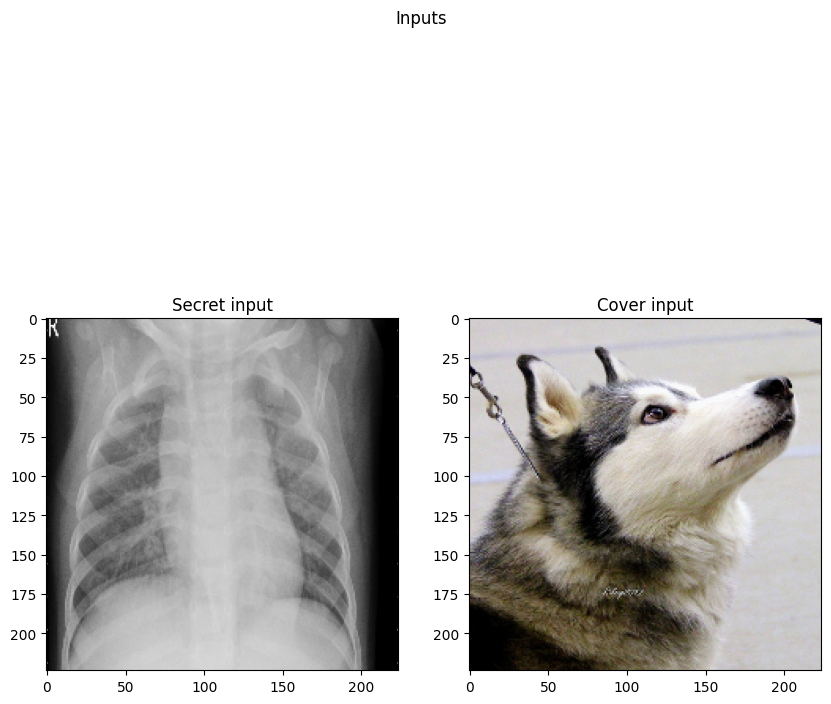

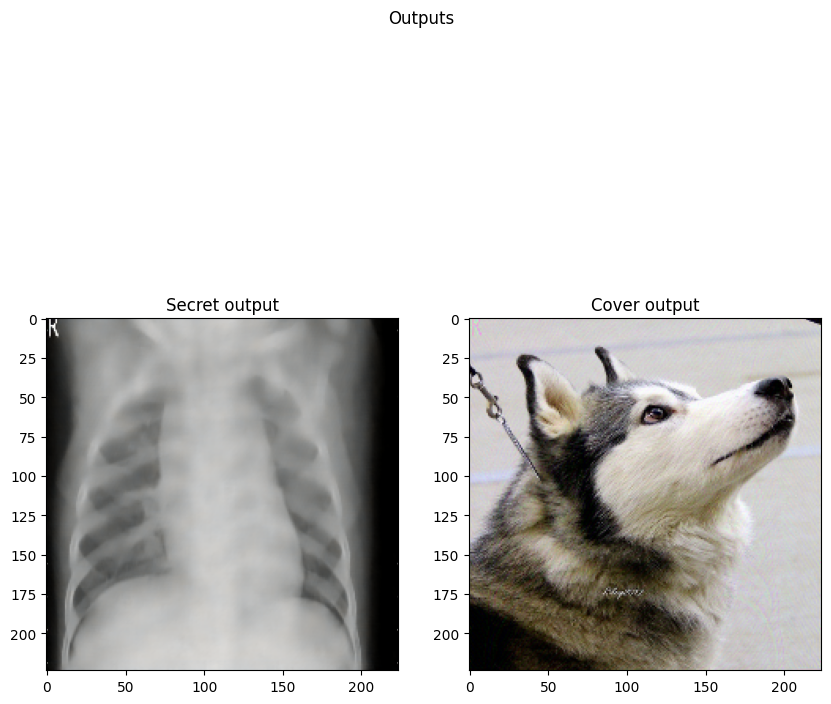

In [22]:
import numpy as np
import random
import keras
import glob
import sys
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from pathlib import Path

'''
Evaluates the trained model on a new dataset
Uses Mean Square Error as evaluation metric
'''

# Path for evaluation dataset
EVAL_PATH_MED = Path(r"artifacts\data_ingestion\Data-CS-DVC\test_data\Med_test\med_im_test").resolve()
EVAL_PATH_COVER= Path(r"artifacts\data_ingestion\Data-CS-DVC\test_data\Cover_test\cover_im_test").resolve()
BATCH_SIZE=1
TEST_NUM=len(glob.glob(str(EVAL_PATH_COVER)))


# Function to convert grayscale image to RGB
def gray_to_rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
# Normalize input for evaluation
def normalize_batch(imgs):

    return (imgs -  np.array([0.485, 0.456, 0.406])) /np.array([0.229, 0.224, 0.225])

# Denormalize output for prediction
def denormalize_batch(imgs,should_clip=True):

    imgs= (imgs * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])

    if should_clip:
        imgs= np.clip(imgs,0,1)
    return imgs

# Create a data generator for evaluation
test_imgen = ImageDataGenerator(rescale = 1./255)

# Compute L2 loss(MSE) for secret image
def custom_loss_1(secret,secret_pred):
    secret_mse = keras.losses.mean_squared_error(secret,secret_pred)
    return secret_mse

# Compute L2 loss(MSE) for cover image
def custom_loss_2(cover,cover_pred):
    cover_mse = keras.losses.mean_squared_error(cover,cover_pred)
    return cover_mse



hide= tf.keras.models.load_model(
            "artifacts/split_model/hiding.h5",custom_objects={'custom_loss_2': custom_loss_2,'custom_loss_1': custom_loss_1}
            , compile=False
        )
reveal= tf.keras.models.load_model(
            "artifacts/split_model/reveal.h5",custom_objects={'custom_loss_2': custom_loss_2,'custom_loss_1': custom_loss_1}
            , compile=False
        )
"""
model = tf.keras.models.load_model(
            r"artifacts\training\steg_model-06-0.03 (1).hdf5",custom_objects={'custom_loss_2': custom_loss_2,'custom_loss_1': custom_loss_1}
            , compile=False
        )

"""

'''
Test the model on a  random pair of images (test)
Plots the input and output for verification
'''

# Perform prediction for single input
def predict(source,cover):

   # Normalize inputs
   secret=np.array(source/255.0)
   cover=np.array(cover/255.0)

   # Predict output
   #coverout,secretout=model.predict([normalize_batch(np.reshape(secret,(1,224,224,3))),normalize_batch(np.reshape(cover,(1,224,224,3)))])

   coverout=hide.predict([normalize_batch(np.reshape(secret,(1,224,224,3))),normalize_batch(np.reshape(cover,(1,224,224,3)))])
   secretout=reveal.predict(coverout)
   # Postprocess output cover image
   coverout = denormalize_batch(coverout)
   coverout=np.squeeze(coverout)*255.0
   coverout=np.uint8(coverout)

   # Postprocess output secret image
   secretout=denormalize_batch(secretout)
   secretout=np.squeeze(secretout)*255.0
   secretout=np.uint8(secretout)

   # Plot output images
   fig_out, ax_out = plt.subplots(1,2, figsize=(10,10))
   fig_out.suptitle('Outputs')
   ax_out[0].title.set_text("Secret output")
   ax_out[0].imshow(secretout)
   ax_out[1].title.set_text("Cover output")
   ax_out[1].imshow(coverout)

# Load random test image pairs
sec=random.sample(os.listdir(str(EVAL_PATH_MED)),k=1)
cov=random.sample(os.listdir(str(EVAL_PATH_COVER)),k=1)
source=np.array(Image.open(str(EVAL_PATH_MED)+'/'+sec[0]))
# Check if the images are grayscale, and convert to RGB if necessary
cover=np.array(Image.open(str(EVAL_PATH_COVER)+'/'+cov[0]))
source=cv2.resize(source, (224,224))
cover=cv2.resize(cover, (224,224))
if source.shape[-1] != 3:
    source = gray_to_rgb(source)
# Plot input images
fig_in, ax_in = plt.subplots(1,2, figsize=(10,10))
fig_in.suptitle('Inputs')
ax_in[0].title.set_text("Secret input")
ax_in[0].imshow(source)
ax_in[1].title.set_text("Cover input")
ax_in[1].imshow(cover)

# Perform prediction
predict(source,cover)

# Sample run: python eval.py dataset/eval_data checkpoints/steg_model-06-0.03.hdf5
